In [1]:
# Import modules
# ipython magic to plot in line
%matplotlib inline
#import mpld3
#mpld3.enable_notebook()
import matplotlib
#matplotlib.style.use('ggplot')
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from astropy.io import ascii
import pytz
# OS interaction
import sys
import os
import glob
import time
plt.rcParams.update({'figure.max_open_warning': 0})

# On Chinook (in CST) we need to tell python we want to display in CST (otherwise UTC is assumed)
if os.name=='posix': # Linux
    os.environ['TZ'] = 'CST'
    time.tzset()

In [2]:
Stations_all = ['BNS','CRG','CRN','FLG','FRG','FRS','PWL']
Station_full_names = ['Bonsai','Can. Ridge','Can. Ridge North','Fortress Ledge','Fortress Ridge','Fortress Ridge South','Powerline']

CST_to_MST = -1 # CST to MST
UTC_to_MST = -7 # UTC (model) to MST

In [3]:
# Set font size
font = {'weight' : 'bold',
        'size'   : 18}
matplotlib.rc('font', **font)

In [4]:
# Directories
# Path to raw data
 # Win path
#mod_dir   = os.path.normpath(r'C:\\Users\\new356\Model_Output\CHM\SnowCast')
#telm_dir  = os.path.normpath(r'Y:\Centre\Marmot Creek\Telemetry\FortressMountain')
 # Linux path
mod_dir   = os.path.normpath(r'/home/nwayand/snow_models/output_CHM/SnowCast/forecast/points')
telm_dir  = os.path.normpath(r'/home/nwayand/hydrology_staff_readonly/Centre/Marmot Creek/Telemetry/FortressMountain')

# Model output ending
mod_ending   = '*_out.txt'

In [5]:
input_format = 'CHM'

In [6]:
if input_format == 'CHM':
    # Ascii data format info
    c_header = 1 # Header lines
    c_column_line = 1 # line where column names start
    c_delimiter = ','

In [7]:
# Move to Model dir
os.chdir(mod_dir) 

In [8]:
def get_recent_CRHO_data_from_telem(csta,data_dir):
    %matplotlib inline
    import os
    import numpy as np
    import pandas as pd
    from astropy.io import ascii

    c_header = 4 # Header lines
    c_column_line = 1 # line where column names start
    c_delimiter = ','

    # Load in file
    cfile = csta + '_0015.dat' # Format for 15 min file
    dat = ascii.read(os.path.join(data_dir,cfile),header_start=c_column_line,data_start=c_header,delimiter=c_delimiter,exclude_names='N/A')
    datain = pd.DataFrame(dat.as_array())

    # Replace -9999 with nan (recomended by netcdf)
    datain.replace(-9999,np.NaN,inplace=True)

    # Make TIMESTAMP the index
    datain['TIMESTAMP'] = datain['TIMESTAMP'].astype('datetime64[ns]')
    datain = datain.set_index('TIMESTAMP')
    
    
    # Telem files saved in CST, convert to MST
    datain.index = datain.index + datetime.timedelta(hours=CST_to_MST)
    # Adjust to local time zone (i.e. from UTC to MST, local_time_offset should = -7)
    #ds['datetime'] = pd.to_datetime(ds.datetime.values) + datetime.timedelta(hours=local_time_offset)
    
    # Import header info 
    headerinfo = pd.read_csv(os.path.join(data_dir,cfile),nrows=2,skiprows=1)
    units = headerinfo.loc[0,:].tolist() # Grab first row of dataframe (units)
    units = units[1:] # Remove first value which is the units of the timestamp

    return {'datain':datain, 'units':units}

In [9]:
def plot_station_weather(modData,obsData_dict):
    ## Multiple axes
    from mpl_toolkits.axes_grid1 import host_subplot
    import mpl_toolkits.axisartist as AA

    #### Var to plot
 
    # Model
    t = modData['t']  # C
    p = modData['p']  # mm/1hr
    p_snow = modData['p_snow'] # mm/1hr
    p_cum = p.cumsum()
    p_snow_cum = p_snow.cumsum()
    ctime = t.index

    # Observed
    obsData = obsData_dict['datain']
    obsUnits = obsData_dict['units']
    obs_t = obsData['AirTemp_Avg'] # C
    if 'Accumulated_Total_NRT' in obsData: # Some stations do not have precip
        obs_p = obsData['Accumulated_Total_NRT'] # mm # need to convert to incremental
        obs_pdiff = obs_p.diff(1) # convert to mm/15min (pandas pads first value as nan!)
        obs_pdiff[obs_pdiff<0] = 0
        obs_pcum = obs_pdiff.cumsum()
    #obs_p_snow = modData['p_snow']    
    obs_ctime = obsData.index
    
    # Aggregate from obs (15min) to mod (1hr) time step
    # TODO

    # Find model's start time in obs time
    def nearestDate(dates, pivot):
        return min(dates, key=lambda x: abs(x - pivot))
    I_S_obs = nearestDate(obs_ctime,ctime[0])
    
    if 'Accumulated_Total_NRT' in obsData: # Some stations do not have precip
        # HACK to make obs cummulative from model start
        obs_pcum = obs_pcum - obs_pcum.loc[I_S_obs]

    # Make new Figure
    fig = plt.figure()
    fig.set_size_inches(16, 8,forward=True)
    host = host_subplot(111, axes_class=AA.Axes)

    plt.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()

    offset = 70
    new_fixed_axis = par2.get_grid_helper().new_fixed_axis
    par2.axis["right"] = new_fixed_axis(loc="right",axes=par2, offset=(offset, 0))

    par2.axis["right"].toggle(all=True)

    host.set_xlim(ctime[0],ctime[len(ctime)-1])
    host.set_ylim(t.min(), t.max())

    host.set_xlabel("Time (MST)")
    host.set_ylabel("Air Temperature (C)")

    par1.set_ylabel("Precipitation (mm)")
    par2.set_ylabel("Frozen Precipitation (mm)")

    # Model
    p1, = host.plot(ctime, t, label="Air Temperature GEM-CHM Modeled",linestyle='--')
    p2, = par1.plot(ctime, p_cum, label="Precipitation GEM-CHM Modeled",linestyle='--')
    p3, = par2.plot(ctime, p_snow_cum, label="Frozen Precip GEM-CHM Modeled",linestyle='--')
    
    # Observed
    obs_p1, = host.plot(obs_ctime, obs_t, label="Air Temperature Observed")
    if 'Accumulated_Total_NRT' in obsData: # Some stations do not have precip    
        obs_p2, = par1.plot(obs_ctime, obs_pcum, label="Precipitation Observed")
    #obs_p3, = par2.plot(ctime, p_snow, label="Observed")

    par1.set_ylim(0, p_cum.max()+10)
    par2.set_ylim(0, p_cum.max()+10)

    host.legend(bbox_to_anchor=[0, 1], loc='upper left')
    
    #host.axis["left"].label.set_color(p1.get_color())
    #par1.axis["right"].label.set_color(p2.get_color())
    host.axis["left"].label.set_color('black')
    par1.axis["right"].label.set_color('black')
    par2.axis["right"].label.set_color(p3.get_color())

    plt.title(staname)

In [10]:
def plot_station_snow_soil(datain,obsData_dict):
    ## Multiple axes
    from mpl_toolkits.axes_grid1 import host_subplot
    import mpl_toolkits.axisartist as AA

    # Var to plot
    
    # Modeled
    var1 = datain['swe']
    var2 = datain['snowdepthavg']
    var3 = datain['snow_albedo']
    ctime = var1.index
    
    # Observed
    obsData = obsData_dict['datain']
    obsUnits = obsData_dict['units']
    if 'SnowDepth' in obsData: # not all stations have snow depth
        obs_SnowDepth = obsData['SnowDepth']*1000 # m to mm
    if 'SWE_scale_Avg' in obsData: # Some stations do not have precip
        obs_swe = obsData['SWE_scale_Avg'] # mm # need to convert to incremental
    #obs_p_snow = modData['p_snow']    
    obs_ctime = obsData.index
    
    # Find common time
    CT_obs = ctime.isin(obs_ctime)

    fig = plt.figure()
    fig.set_size_inches(14, 8,forward=True)
    host = host_subplot(111, axes_class=AA.Axes)

    plt.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()

    offset = 120
    new_fixed_axis = par2.get_grid_helper().new_fixed_axis
    par2.axis["right"] = new_fixed_axis(loc="right",axes=par2, offset=(offset, 0))

    par2.axis["right"].toggle(all=True)
    
    host.set_xlim(ctime[0],ctime[len(ctime)-1])
    if (var1.max()>0):
        host.set_ylim(0, var1.max())
    else:
        host.set_ylim(0, 10)
    

    host.set_xlabel("Time (MST)")
    host.set_ylabel("SWE (mm)")

    par1.set_ylabel("Snow Depth (mm)")
    par2.set_ylabel("Snow Albedo (-)")

    # Plot Model
    p1, = host.plot(ctime, var1, label="SWE Modeled",linestyle='--')
    p2, = par1.plot(ctime, var2, label="Snow Depth Modeled",linestyle='--')
    p3, = par2.plot(ctime, var3, label="Snow Albedo Modeled",linestyle='--')
    
    # Plot Observations
    if 'SWE_scale_Avg' in obsData: # Some stations do not have precip
        obs_p1, = host.plot(obs_ctime, obs_swe, label="SWE Observed")
    if ('SnowDepth' in obsData): # not all stations have snow depth
        #obs_SnowDepth_trim = obs_SnowDepth[CT_obs]
        obs_p2, = par1.plot(obs_ctime, obs_SnowDepth, label="Snow Depth Observed")
        par1.set_ylim(0, np.min([np.max([var2.max(),obs_SnowDepth.max()]),500]))
    else:
        par1.set_ylim(0, var2.max())

    #obs_p3, = par2.plot(ctime, var3, label="Snow Albedo (-)")   

    par2.set_ylim(0, 1)

    host.legend(bbox_to_anchor=[0, 1], loc='upper left')

    host.axis["left"].label.set_color(p1.get_color())
    par1.axis["right"].label.set_color(p2.get_color())
    par2.axis["right"].label.set_color(p3.get_color())

    plt.title(staname)
    
    # Try to rotate the time
    #par1.axis["bottom"].major_ticklabels.set_axis_direction("left")
    #par1.axis["bottom"].major_ticklabels.set_rotation(90)

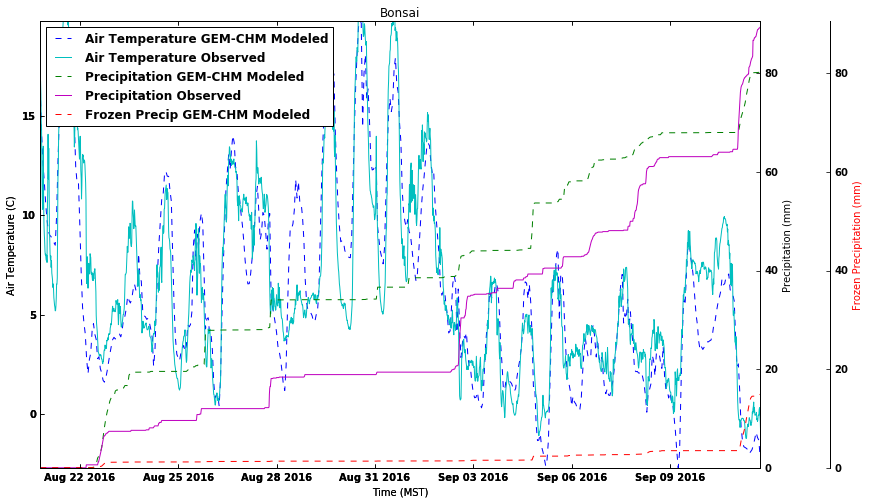

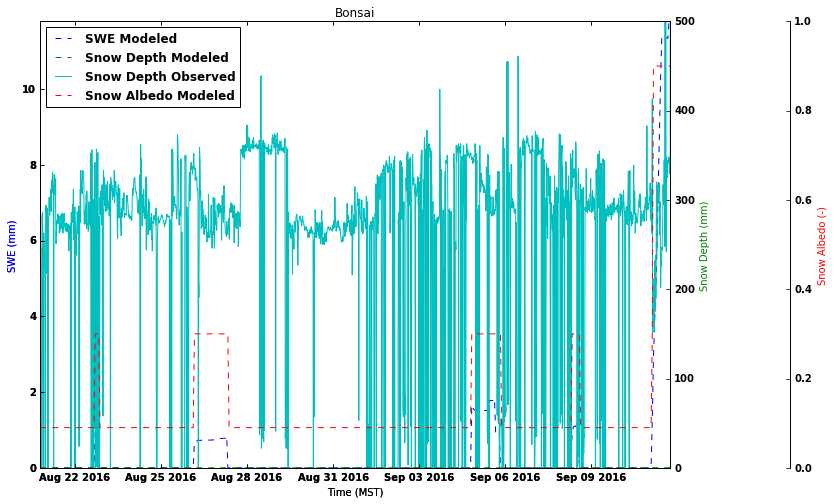

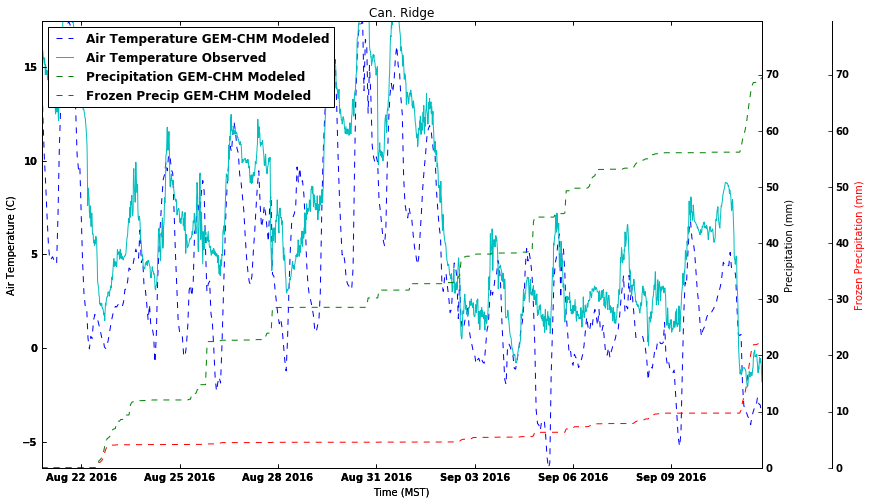

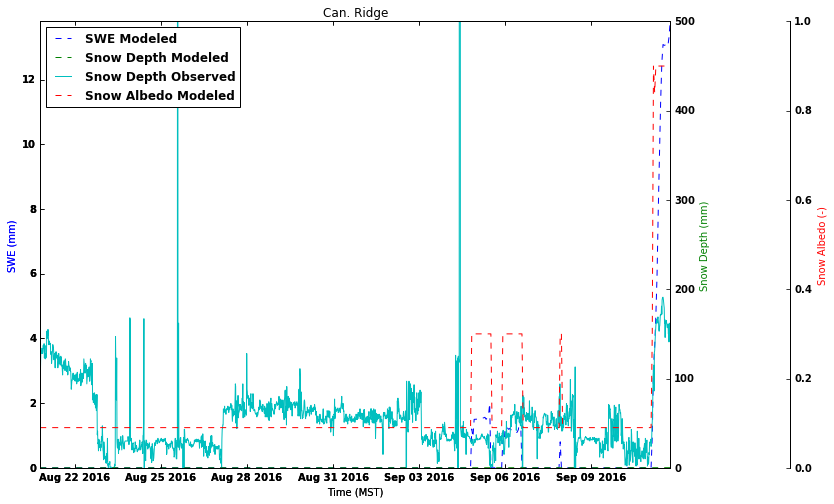

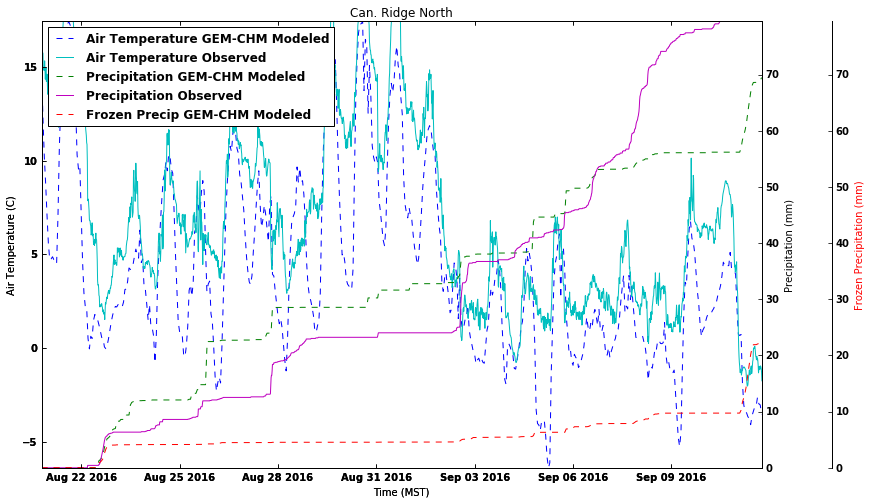

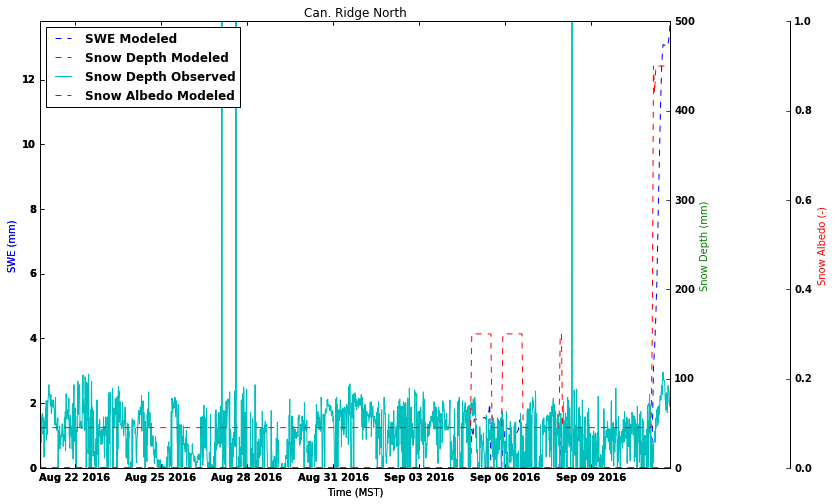

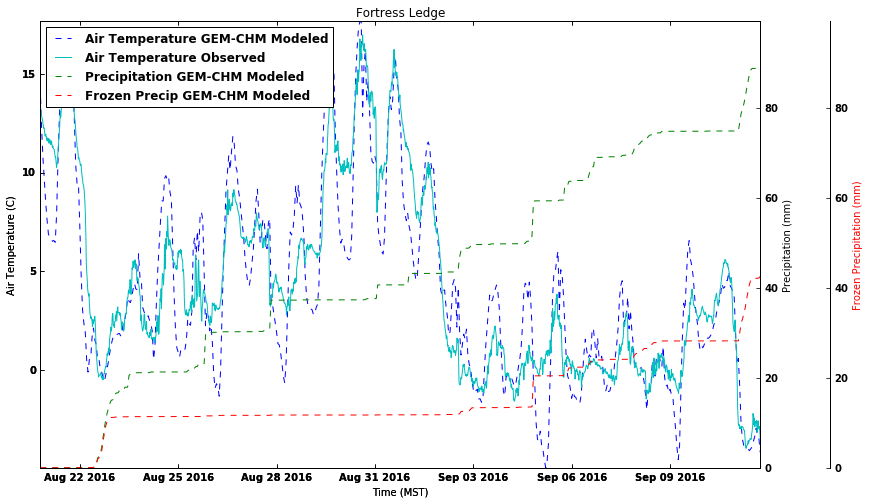

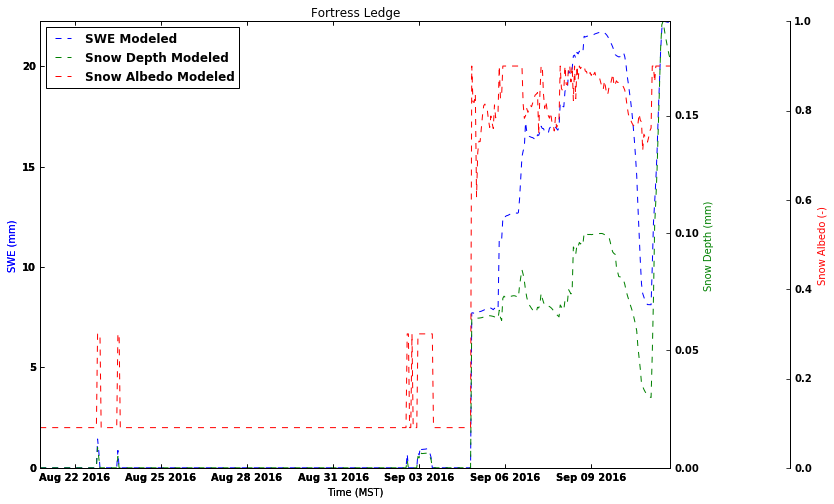

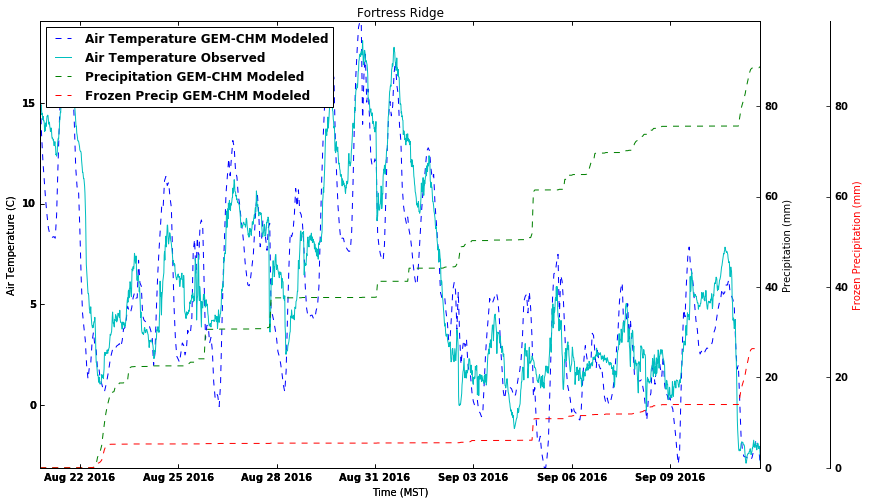

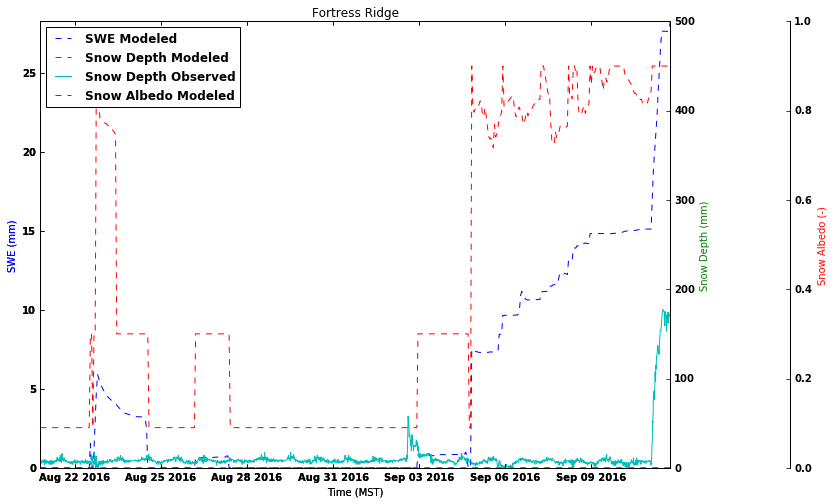

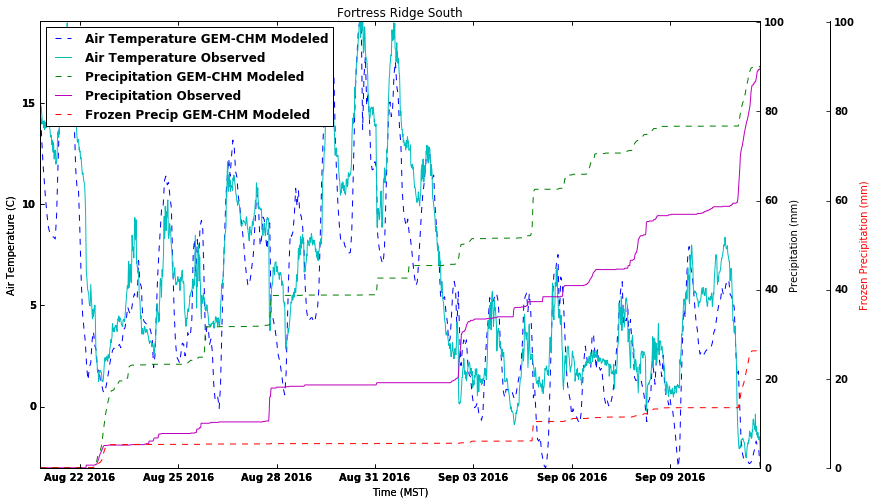

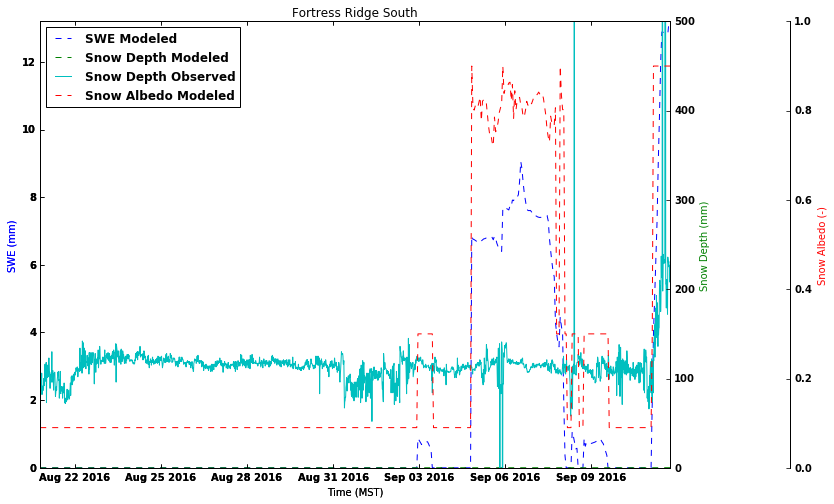

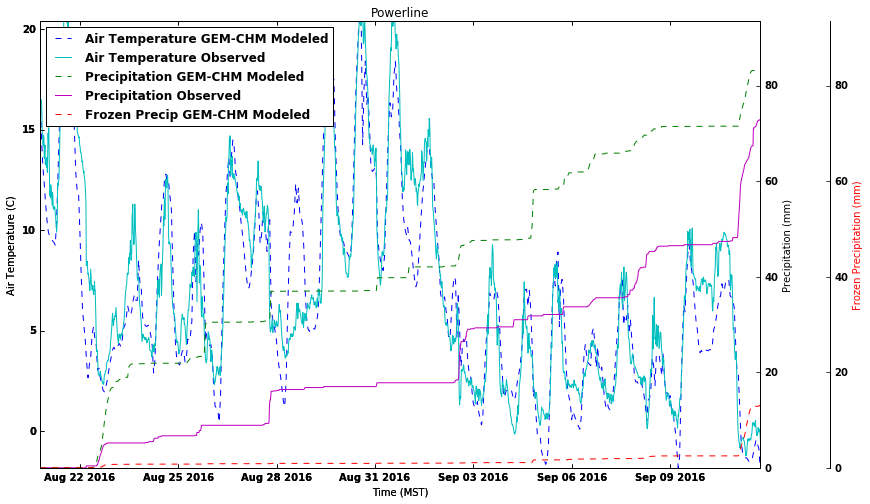

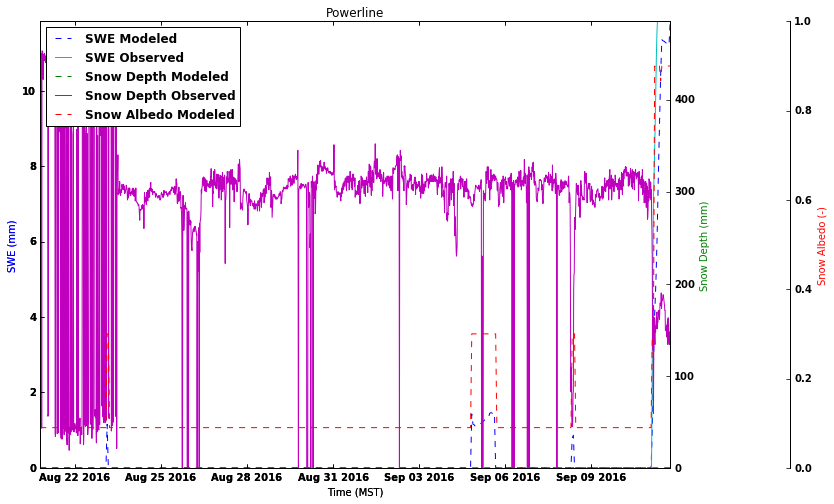

In [11]:
# For Each station
for cSta,staname in zip(Stations_all,Station_full_names):
    #print(staname)
    ###### Import model output file
    cfile = cSta + '_out.txt'
    
    # Import data to pandas dataframe
    modData = pd.read_csv(cfile,sep=",",parse_dates=True) 
    modData.set_index('datetime',inplace=True)

    # Make datetime the index
    modData.index = pd.to_datetime(modData.index)
    modData.index = modData.index + datetime.timedelta(hours=UTC_to_MST)

    # Get Telem Observation data
    obsData = get_recent_CRHO_data_from_telem(cSta,telm_dir)

    ###########################
    # Plot key vars for station
    ###########################
    
    plot_station_weather(modData,obsData)
    
    plot_station_snow_soil(modData,obsData)
    plt.show()
    